In [11]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
def guiyi(*fea):
    fea_matrix=np.array(fea[0])
    for f in fea:
        f=(f-f.min())/(f.max()-f.min()).reshape(-1,1)
        fea_matrix = np.hstack((fea_matrix,f))
    
    return fea_matrix[:,1:]

In [13]:
from utils.feature_extraction import find_peak_trough,feature_extraction
from os import listdir
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
file_list = listdir('data')
m = len(file_list)
fea_matrix=np.empty([0,7])

train_size=0

for i in range(m):
    if i %3 ==1:
        continue
    file_name = './data/'+file_list[i]
    data = np.loadtxt(file_name, dtype=np.int16, skiprows=1)

    peaks, troughs = find_peak_trough(data, 54)
    f1, f2, f3, f4, f5, f8, f9, f10 = feature_extraction(
        data, peaks, troughs)

    if(i<int(0.7*m)):
        train_size+=f1.shape[0]
    
    label=np.full((f1.shape[0],1),int(i%3>0)).reshape(-1,1) #  label=np.full((f1.shape[0],1), i%3).reshape(-1,1)

    concated_matrix=np.hstack((f1,f3,f4,f5,f8,f9)) # 拼接起来的特征矩阵
    concated_matrix=scaler.fit_transform(concated_matrix) # 经过归一化

    # concated_matrix=guiyi(f1,f3,f4,f5,f8,f9) # 与上面两行同理

    temp= np.hstack((concated_matrix,label)) # 特征-标签矩阵
    fea_matrix=np.vstack((fea_matrix,temp))

print(train_size)

8375


In [14]:
from utils.data_splitter import get_sequence
from reciever import SEQ_LENGTH

temporal_features , labels = get_sequence(data=fea_matrix, seq_length=SEQ_LENGTH,device=device,to_device=True)
print("len of  all  data  is : {}".format( temporal_features.shape )) 
print("len of  all  label is : {}".format( labels.shape )) 

trainX = temporal_features[0:train_size]
trainY = labels[0:train_size]
print("len of train data  is : {}".format( trainX.shape )) 
print("len of train label is : {}".format( trainY.shape ))

# testX = temporal_features[train_size:]
# testY = labels[train_size:]
# print("len of  test data  is : {}".format( testX.shape )) 
# print("len of  test label is : {}".format( testY.shape ))

len of  all  data  is : torch.Size([12229, 3, 6])
len of  all  label is : torch.Size([12229])
len of train data  is : torch.Size([8375, 3, 6])
len of train label is : torch.Size([8375])


In [21]:
def analyze(labels,prediction,train_size,need_print=False):
    total_size = labels.shape[0]
    correct_prediction_in_train = sum(
        prediction[0:train_size] == labels[0:train_size])  # 训练集上正确预测的样本数
    correct_prediction_in_test = sum(
        prediction[train_size:] == labels[train_size:])  # 测试集上正确预测的样本数
    total_correct_prediction = correct_prediction_in_train + \
        correct_prediction_in_test  # 全体数据正确预测的样本数

    total_accuracy=total_correct_prediction/total_size
    train_accuracy=correct_prediction_in_train/train_size
    test_accuracy=correct_prediction_in_test/(total_size-train_size)

    if need_print:
        print("%-5d / %-5d = %.3f" % (total_correct_prediction, total_size, total_accuracy))
        print("%-5d / %-5d = %.3f" % (correct_prediction_in_train, train_size,train_accuracy ))
        print("%-5d / %-5d = %.3f" % (correct_prediction_in_test, total_size-train_size,test_accuracy ))

    return total_accuracy,train_accuracy,test_accuracy

In [22]:
from utils.model import model
from utils.plot import plot
from reciever import INPUT_SIZE
from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter('./log')

num_epochs =5000

input_size=INPUT_SIZE
output_size=2
hidden_size=5
num_layers=4

lstm = model(input_size=input_size,output_size=output_size, hidden_size=hidden_size,num_layers=num_layers,device=device).to(device)

loss_function = torch.nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(lstm.parameters(), lr=0.0005)

for epoch in range(num_epochs):
    epoch+=1
    # torch.manual_seed(epoch)
    prediction=lstm(trainX)
    
    trainY_one_hot=F.one_hot(trainY.long()).float()
    loss = loss_function(prediction,trainY_one_hot)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # writer.add_scalar('Loss/Train',loss.item() ,epoch)

    if epoch % 100 == 0:

      lstm.eval()
      prediction = lstm(temporal_features)
      labels_one_hot=F.one_hot(labels.long()).float()
      loss =loss_function(prediction,labels_one_hot)
      # writer.add_scalar('Loss/Test',loss.item() ,epoch)

      prediction_plot = prediction.cpu().detach().numpy().argmax(axis=1)
      labels_plot=labels.cpu().numpy()

      # plot(labels_plot,prediction_plot,train_size)
      total_accuracy,train_accuracy,test_accuracy=analyze(labels_plot, prediction_plot, train_size,need_print=False)

      # writer.add_scalar('Acc/Total',total_accuracy ,epoch)
      # writer.add_scalar('Acc/Train',train_accuracy ,epoch)
      # writer.add_scalar('Acc/Test', test_accuracy, epoch)
      print("Epoch : %5d | loss : %1.5f | total_acc : %1.5f | train_acc : %1.5f | test_acc : %1.5f" % (epoch, loss.item(),total_accuracy,train_accuracy,test_accuracy))

      lstm.train()


Epoch :   100 | loss : 0.69401 | total_acc : 0.48843 | train_acc : 0.51260 | test_acc : 0.43591
Epoch :   200 | loss : 0.69337 | total_acc : 0.48843 | train_acc : 0.51260 | test_acc : 0.43591
Epoch :   300 | loss : 0.64921 | total_acc : 0.64601 | train_acc : 0.65540 | test_acc : 0.62558
Epoch :   400 | loss : 0.61456 | total_acc : 0.68190 | train_acc : 0.69278 | test_acc : 0.65828
Epoch :   500 | loss : 0.61351 | total_acc : 0.68092 | train_acc : 0.69361 | test_acc : 0.65335
Epoch :   600 | loss : 0.61308 | total_acc : 0.68125 | train_acc : 0.69887 | test_acc : 0.64297
Epoch :   700 | loss : 0.62108 | total_acc : 0.65516 | train_acc : 0.71510 | test_acc : 0.52491
Epoch :   800 | loss : 0.61878 | total_acc : 0.68051 | train_acc : 0.77122 | test_acc : 0.48339
Epoch :   900 | loss : 0.60171 | total_acc : 0.70259 | train_acc : 0.79379 | test_acc : 0.50441
Epoch :  1000 | loss : 0.58535 | total_acc : 0.71633 | train_acc : 0.80322 | test_acc : 0.52750
Epoch :  1100 | loss : 0.56784 | total_a

9747  / 12229 = 0.797
7500  / 8375  = 0.896
2247  / 3854  = 0.583


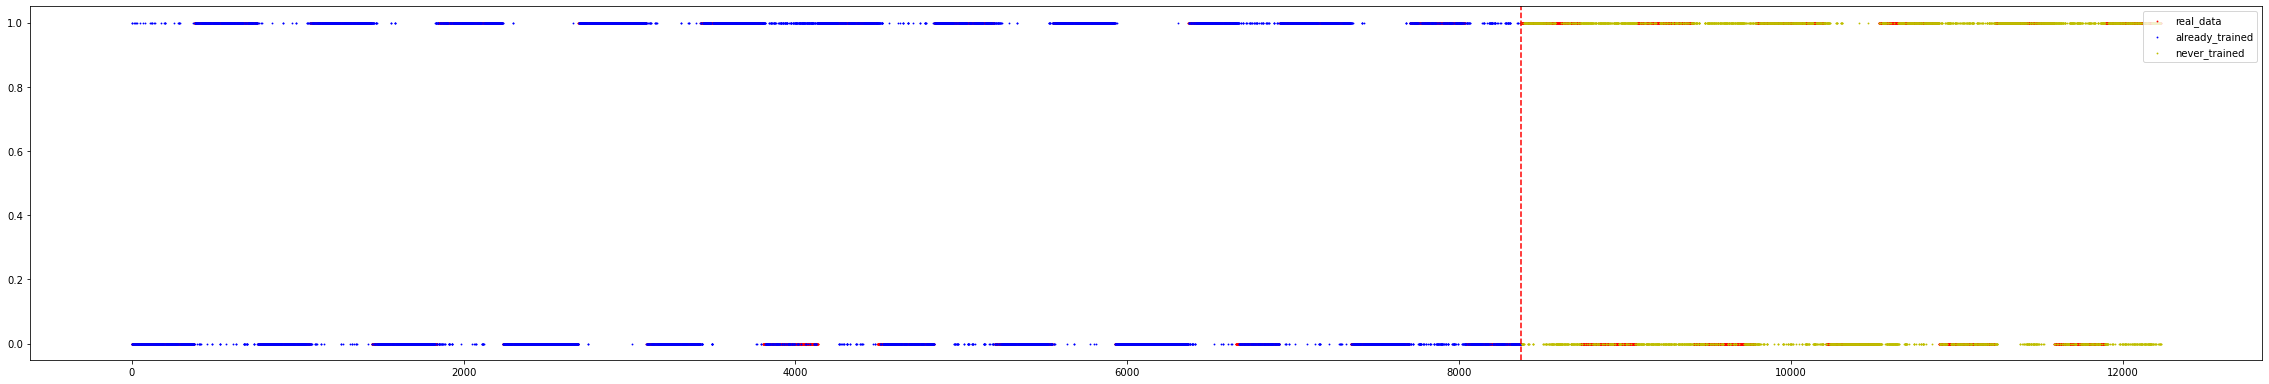

In [26]:
lstm.eval()

prediction = lstm(temporal_features)
prediction_plot = prediction.cpu().detach().numpy().argmax(axis=1)

# lst=[]
# THETA=0.9
# weight_array=np.array([THETA**(i+1) for i in range(5)])
# print(weight_array)
# for i in range(3):
    # print(i)

labels_plot=labels.cpu().numpy()

analyze(labels_plot, prediction_plot, train_size,need_print=True)
plot(labels_plot,prediction_plot,train_size)

In [55]:
import os
if not os.path.exists('model'):
    os.mkdir('./model')

torch.save(lstm,'./model/lstm.pkl')

In [10]:
jgh=torch.load('model/lstm.pkl')
jgh

model(
  (lstm): LSTM(6, 5, num_layers=4, batch_first=True)
  (fc1): Linear(in_features=5, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=2, bias=True)
  (softmax): Softmax(dim=-1)
)